# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.


The dataset is montly_champagne_sales

In [1]:
import datetime as dt 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

## 02 - Load Data
Let's start by loading the time series of the challenge

In [4]:
df = pd.DataFrame(pd.read_csv("C:/Users/kawta/OneDrive/Bureau/EDC/Python Avancé/Projet2/03-SARIMA/data/monthly_champagne_sales.csv", index_col='Month'))
df.head()

,Sales
Month,
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


👉 Convert dataframe with datetime objects as index to make it look like this
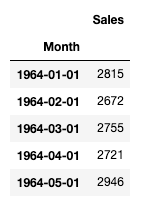

In [5]:
#data = data.set_index(data.columns == 'datetime')
df.index = pd.to_datetime(df.index)

In [7]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

Text(0.5, 1.0, 'Evolution of sales over time')

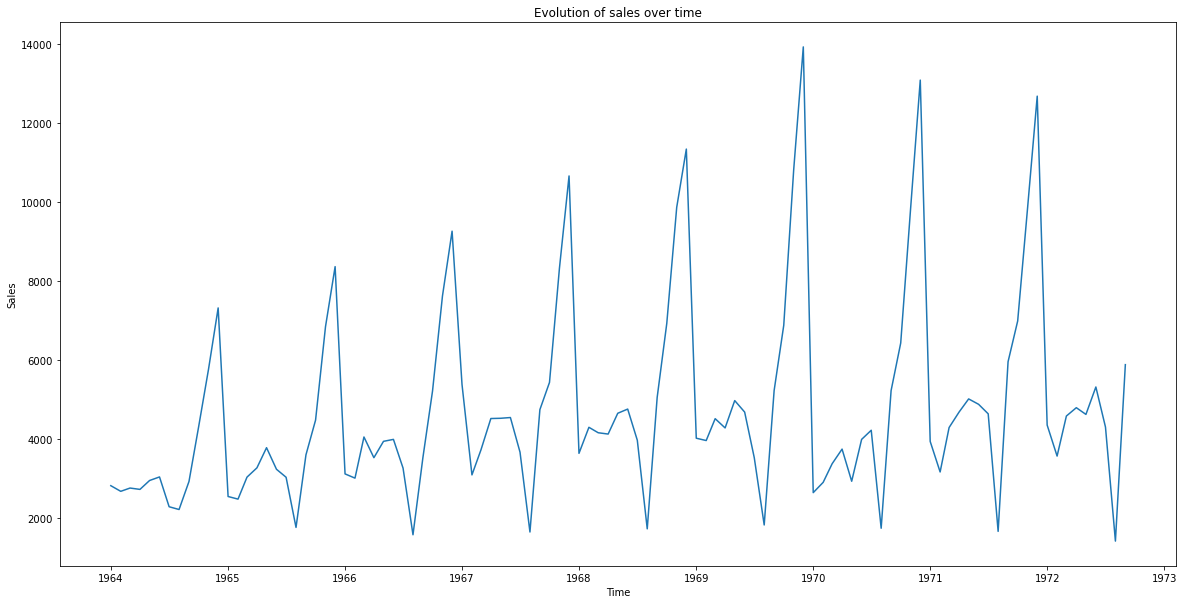

In [17]:
plt.figure(figsize=(20,10))
plt.plot(df.Sales)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Evolution of sales over time')


If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

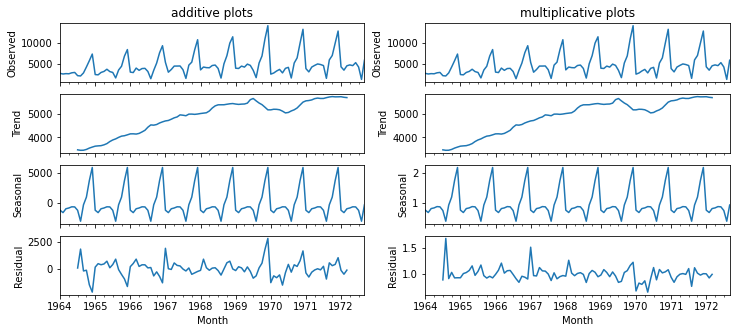

In [19]:
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
cols = ['additive plots', 'multiplicative plots']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
#1)
additive = seasonal_decompose(df,model='additive')
plotseasonal(additive,axes[:,0]);

#2)
multiplicative = seasonal_decompose(df, model='multiplicative')
plotseasonal(multiplicative,axes[:,1])


👉 De-seasonalize this time serie using the decomposition of your choice

<AxesSubplot:title={'center':'diff'}, xlabel='Month'>

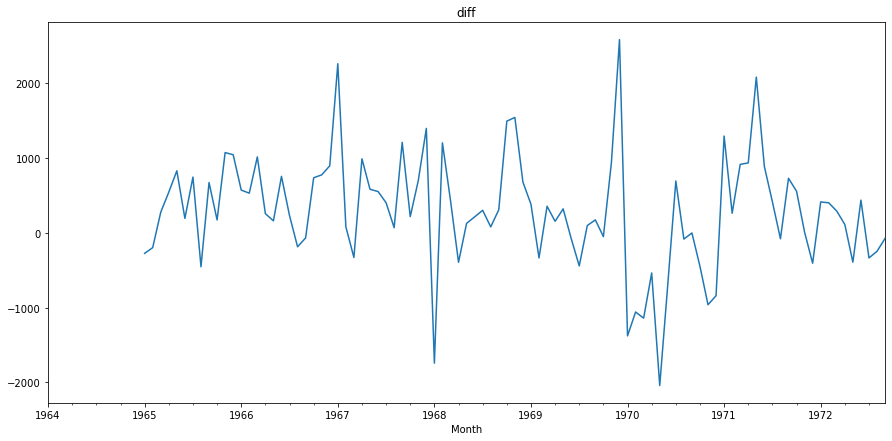

In [21]:
diff = df.Sales.diff(12)  
fig = plt.figure(figsize=(15,7))
diff.plot(title='diff')



☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [22]:
date = dt.date(1970,1,1)
df_train = df.Sales[df.index.date < date]
df_test = df.Sales[df.index.date >= date]

print('df_train dimension : {}\ndf_test dimension : {}'.format(df_train.shape,df_test.shape))

df_train dimension : (72,)
df_test dimension : (33,)


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [24]:
print('p-value: ', adfuller(df.Sales)[1])


p-value:  0.363915771660244


In [ ]:
ici on voit très bien que p-value est supérieure à 0.05 , ce qui signifie que la série est non-stationnaire


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

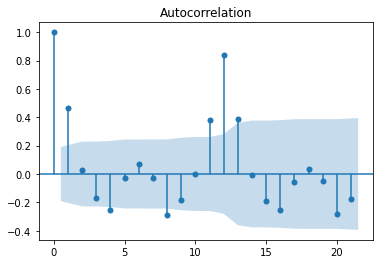

In [25]:
plot_acf(df.Sales);


### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

p-value :  2.060579696813685e-11


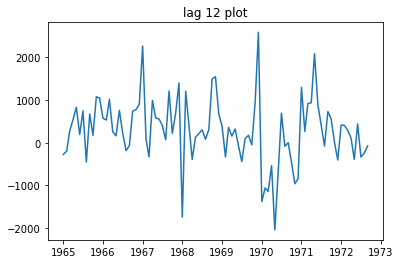

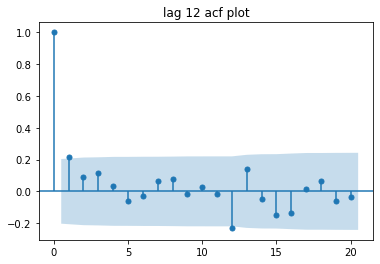

In [26]:
y = df.Sales.diff(12).dropna()

print('p-value : ',adfuller(y)[1])
plt.plot(y);
plt.title('lag 12 plot')
plot_acf(y);
plt.title('lag 12 acf plot')
plt.show()


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

p-value :  0.00026504628492933995


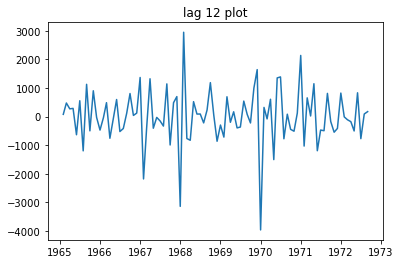

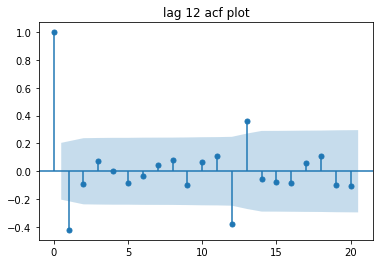

In [27]:


y_diff = y.diff(1).dropna()

print('p-value : ', adfuller(y_diff)[1])
plt.plot(y_diff);
plt.title('lag 12 plot')
plot_acf(y_diff);
plt.title('lag 12 acf plot')
plt.show()



👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

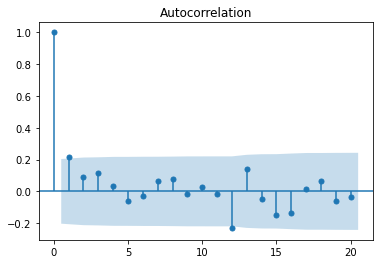

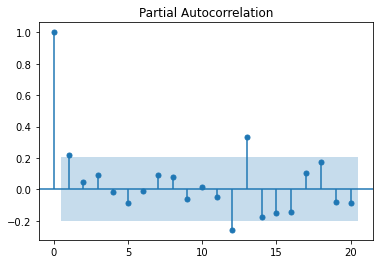

In [29]:
plot_acf(y);
plot_pacf(y);


☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [30]:
model = pm.auto_arima(df_train,
                      n_jobs=-1,
                      seasonal=True,
                      m=12,
                      D=1,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2, 
                      d=0,  
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.418 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood 

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [31]:
y_forecast, conf_int  = model.predict(len(df_test),return_conf_int=True,alpha=0.05)
upper = conf_int[:,1]
lower = conf_int[:,0]

In [32]:
central = pd.Series(y_forecast, index=df_test.index)
upper = pd.Series(conf_int[:,1], index=df_test.index) 
lower = pd.Series(conf_int[:,0], index=df_test.index)

👇 Run the cell below to plot your predictions against reality

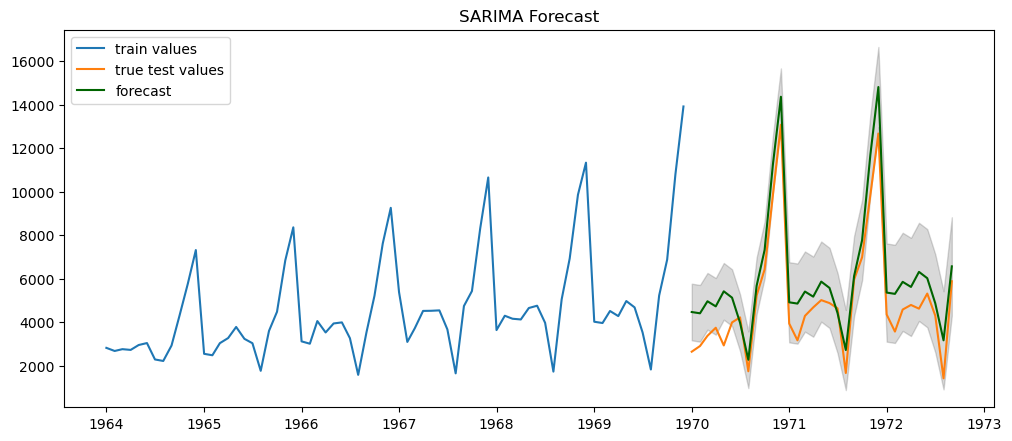

In [33]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1270      0.176      0.723      0.469      -0.217       0.471
ma.L1         -1.0000      0.203     -4.925      0.000      -1.398      -0.602
ar.S.L12      -0.0156      0.231     -0.068      0.946      -0.469       0.437
ma.S.L12      -0.1452      0.244     -0.595      0.552      -0.623       0.333
sigma2      5.032e+05   4.04e-07   1.25e+12      0.000    5.03e+05    5.03e+05


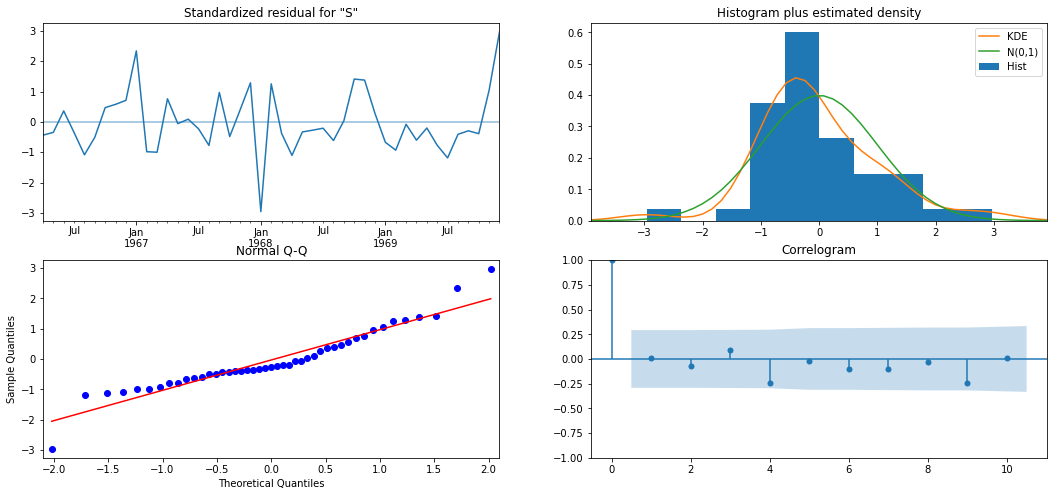

In [35]:
# Build and train the model , try with differents (p,d,q) and (P,D,Q,s) 
sarima = SARIMAX(df_train, order=(1,1,1), 
                 seasonal_order=(1,1,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False)
results = sarima.fit(disp=-1)

# Some diagnostics plots 
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(18, 8))
plt.show()

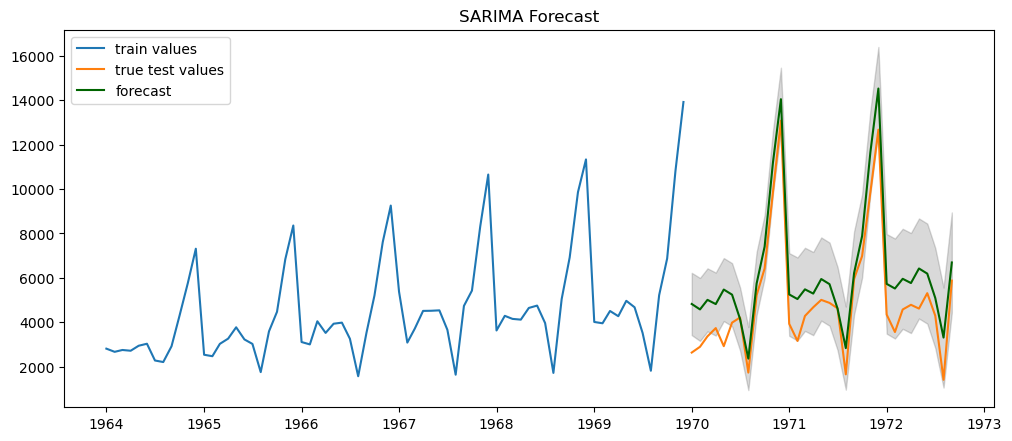

In [36]:
# Predictions 
preds = results.get_prediction(start=len(df_train), end=(len(df_train)+len(df_test)-1), dynamic=len(df_test)-1)
conf_ci = preds.conf_int()

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(preds.predicted_mean, color='darkgreen',label = "forecast")
plt.fill_between(conf_ci.index, 
                 conf_ci.iloc[:,0], 
                 conf_ci.iloc[:,1], 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [20]:
# Add lagged values
df_new = df.copy()
for i in range(1,13):
    df_new = pd.concat((df_new, df.Sales.shift(i).rename('Shift_{}'.format(i))), axis=1)
print('df_new shape before removing Nan : {}'.format(df_new.shape)) 

# Drop nan
df_new.dropna(inplace=True)
print('df_new shape after removing Nan : {}'.format(df_new.shape))

# create df_train and df_test 
df_new_train = df_new.iloc[df_new.index < pd.to_datetime(date)]
df_new_test = df_new.iloc[df_new.index >= pd.to_datetime(date)]
print('df_train_new dimension : {}\ndf_test_new dimension : {}'.format(df_new_train.shape, df_new_test.shape))

df_new shape before removing Nan : (105, 13)
df_new shape after removing Nan : (93, 13)
df_train_new dimension : (60, 13)
df_test_new dimension : (33, 13)


In [21]:
# Keep track of test_indexes
test_indexes = df_new_test.reset_index().index.values+1
test_indexes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [22]:
# Create X, y
X = df_new.drop('Sales', axis=1)
y = df_new.Sales

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [23]:
rf = RandomForestRegressor()

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [24]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx+1]
        current_ground_truth = y_true[_indx+1]
        current_ground_truth_features = full_X[_indx+1,:]
        train_features = full_X[:_indx+1]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [25]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=rf, full_X = X.values)

In [26]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.22908593300462848

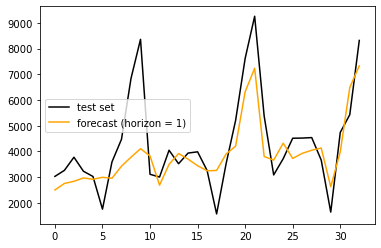

In [27]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [28]:
# Extract the trend using a well chosen moving average

<AxesSubplot:xlabel='Month'>

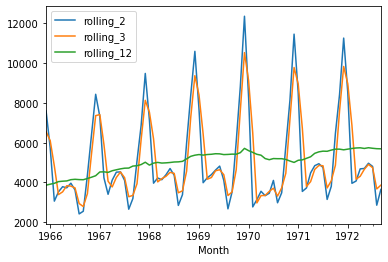

In [29]:
df_new['rolling_2'] = df_new.Sales.rolling(2).mean()
df_new['rolling_3'] = df_new.Sales.rolling(3).mean()
df_new['rolling_12'] = df_new.Sales.rolling(12).mean()
df_new.dropna(inplace=True)

df_new['rolling_2'].plot(legend='rolling 2')
df_new['rolling_3'].plot(legend='rolling 3')
df_new['rolling_12'].plot(legend='rolling 12')

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

<AxesSubplot:xlabel='Month'>

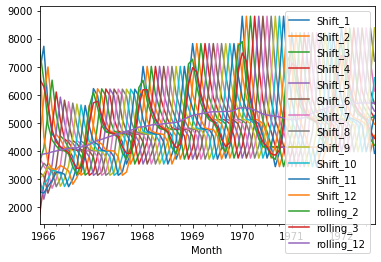

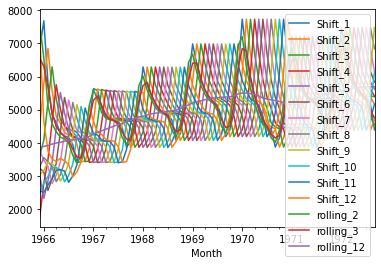

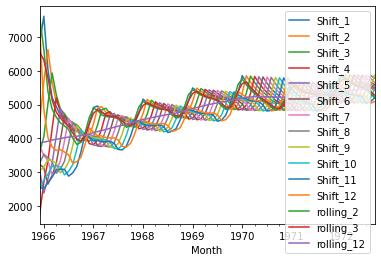

In [30]:
df2 = df_new.ewm(halflife=2).mean().drop('Sales', axis=1)
df3 = df_new.ewm(halflife=3).mean().drop('Sales', axis=1)
df12 = df_new.ewm(halflife=12).mean().drop('Sales', axis=1)

df2.plot()
df3.plot()
df12.plot()

You should see a better MAPE!

In [31]:
results2 = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=rf, full_X = df2.values)
results3 = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=rf, full_X = df3.values)
results12 = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=rf, full_X = df12.values)


print(results2[2], results3[2], results12[2])
# MAPE is not better so this part is wrong 

0.29463059541485404 0.3117317926738866 0.34841405379369966


Try to look at the importance of each feature. What do you find?


In [32]:
## ? 
df_new.corrwith(df_new.Sales) ## shift 12, shift 1 , rolling 2 and 3 columns are very correlated with the Sales

Sales         1.000000
Shift_1       0.418401
Shift_2      -0.052665
Shift_3      -0.254177
Shift_4      -0.353686
Shift_5      -0.094770
Shift_6       0.010326
Shift_7      -0.080143
Shift_8      -0.357576
Shift_9      -0.235393
Shift_10     -0.030213
Shift_11      0.407092
Shift_12      0.955586
rolling_2     0.841792
rolling_3     0.639974
rolling_12    0.147747
dtype: float64

### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA

In [33]:
## THERE IS AN ISSUE WITH i = 1 I DON'T KNOW WHY 

def train_models(train, test,):
    
    MAPE = {}
    diff = {}
    for i in range(2, len(test)+1):
        print(i)
        arima = pm.auto_arima(train,
                          n_jobs=-1,
                          seasonal=True,
                          D=1,
                          m=i,
                          start_p=0, max_p=5,
                          start_q=0, max_q=5,
                          start_P=0, max_P=5,
                          start_Q=0, max_Q=5, 
                          d=0,  
                          trace=True, error_action='ignore',  suppress_warnings=True)
        s = SARIMAX(train, 
                order = arima.get_params()['order'], 
                seasonal_order=arima.get_params()['seasonal_order'],
                enforce_stationarity=False,
                enforce_invertibility=False).fit(disp=-1)
        
        predictions = s.get_prediction(start=len(train), end=(len(train)+len(test)-1), dynamic=len(test)-1)
        mape =  np.mean(np.abs(np.array(predictions.predicted_mean) - np.array(df_test))/np.abs(np.array(df_test)))
        
        MAPE['horizon {}'.format(i)] = mape
        diff['horizon {}'.format(i)] = np.abs(mape - 0.21450134068379123)   #this was the result of mape 
                                                                    #for the sarima model form before 
    return MAPE, diff
#sarimax = SARIMAX()

In [34]:
MAPE, diff = train_models(df_train,df_test)

## horizon 12 gives the best result 

2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=1325.847, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=1307.378, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=1324.441, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=1314.390, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=1283.185, Time=0.09 sec
 ARIMA(1,0,0)(3,1,0)[2] intercept   : AIC=1285.157, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=1264.213, Time=0.22 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(3,1,1)[2] intercept   : AIC=1287.043, Time=0.18 sec
 ARIMA(1,0,0)(2,1,2)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(1,1,2)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(3,1,2)[2] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=1310.297, Time=0.06 sec
 ARIMA(1,0,1)(2,1,1)[2] intercept   : AIC=inf, Time=0.27

 ARIMA(2,0,1)(1,1,2)[6] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,0,0)(1,1,2)[6]             : AIC=inf, Time=0.37 sec

Best model:  ARIMA(1,0,0)(1,1,2)[6] intercept
Total fit time: 7.432 seconds
7
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1239.337, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1204.432, Time=0.03 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1181.999, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1238.447, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=1200.774, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=1183.732, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=1183.594, Time=0.28 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=1189.341, Time=0.09 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=1183.892, Time=0.12 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AI

 ARIMA(2,0,1)(0,1,1)[11] intercept   : AIC=1118.522, Time=0.27 sec
 ARIMA(1,0,2)(0,1,1)[11] intercept   : AIC=1117.929, Time=0.33 sec
 ARIMA(0,0,2)(0,1,1)[11] intercept   : AIC=1116.870, Time=0.32 sec
 ARIMA(2,0,0)(0,1,1)[11] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,2)(0,1,1)[11] intercept   : AIC=1115.604, Time=0.41 sec
 ARIMA(2,0,2)(0,1,0)[11] intercept   : AIC=1124.937, Time=0.11 sec
 ARIMA(2,0,2)(1,1,1)[11] intercept   : AIC=1116.541, Time=0.50 sec
 ARIMA(2,0,2)(0,1,2)[11] intercept   : AIC=1117.603, Time=0.70 sec
 ARIMA(2,0,2)(1,1,0)[11] intercept   : AIC=1115.077, Time=0.33 sec
 ARIMA(2,0,2)(2,1,0)[11] intercept   : AIC=1115.395, Time=0.64 sec
 ARIMA(2,0,2)(2,1,1)[11] intercept   : AIC=1117.458, Time=0.83 sec
 ARIMA(1,0,2)(1,1,0)[11] intercept   : AIC=1121.872, Time=0.23 sec
 ARIMA(2,0,1)(1,1,0)[11] intercept   : AIC=1125.045, Time=0.10 sec
 ARIMA(3,0,2)(1,1,0)[11] intercept   : AIC=1122.721, Time=0.34 sec
 ARIMA(2,0,3)(1,1,0)[11] intercept   : AIC=1121.520, Time=0.48 sec


 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(2,1,1)[16] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(1,1,0)[16] intercept   : AIC=1071.812, Time=0.05 sec
 ARIMA(2,0,0)(1,1,0)[16] intercept   : AIC=1047.619, Time=0.27 sec
 ARIMA(2,0,0)(0,1,0)[16] intercept   : AIC=1060.338, Time=0.02 sec
 ARIMA(2,0,0)(2,1,0)[16] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,0,0)(1,1,1)[16] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,0)(0,1,1)[16] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(2,1,1)[16] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(3,0,0)(1,1,0)[16] intercept   : AIC=1047.150, Time=0.31 sec
 ARIMA(3,0,0)(0,1,0)[16] intercept   : AIC=1059.623, Time=0.03 sec
 ARIMA(3,0,0)(2,1,0)[16] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(3,0,0)(1,1,1)[16] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(3,0,0)(0,1,1)[16] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,0,0)(2,1,1)[16] intercept   : AIC=in

 ARIMA(1,0,0)(3,1,0)[20] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(1,0,0)(2,1,1)[20] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(1,0,0)(1,1,1)[20] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,0,0)(3,1,1)[20] intercept   : AIC=inf, Time=5.07 sec
 ARIMA(0,0,0)(2,1,0)[20] intercept   : AIC=983.122, Time=1.23 sec
 ARIMA(2,0,0)(2,1,0)[20] intercept   : AIC=966.783, Time=2.95 sec
 ARIMA(2,0,0)(1,1,0)[20] intercept   : AIC=974.372, Time=0.90 sec
 ARIMA(2,0,0)(3,1,0)[20] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(2,0,0)(2,1,1)[20] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(2,0,0)(1,1,1)[20] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,0,0)(3,1,1)[20] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(3,0,0)(2,1,0)[20] intercept   : AIC=970.858, Time=1.52 sec
 ARIMA(2,0,1)(2,1,0)[20] intercept   : AIC=965.390, Time=1.55 sec
 ARIMA(2,0,1)(1,1,0)[20] intercept   : AIC=973.584, Time=0.59 sec
 ARIMA(2,0,1)(3,1,0)[20] intercept   : AIC=963.477, Time=4.41 sec
 ARIMA(2,0,1)(4,1,0)[20] intercept   : AIC

 ARIMA(1,0,0)(1,1,0)[25] intercept   : AIC=863.919, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[25] intercept   : AIC=863.544, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[25]             : AIC=870.518, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[25] intercept   : AIC=863.970, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[25] intercept   : AIC=863.938, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[25] intercept   : AIC=865.852, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[25] intercept   : AIC=862.505, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[25] intercept   : AIC=862.120, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[25] intercept   : AIC=858.881, Time=0.28 sec
 ARIMA(1,0,1)(1,1,0)[25] intercept   : AIC=861.894, Time=0.32 sec
 ARIMA(1,0,1)(0,1,1)[25] intercept   : AIC=858.849, Time=0.88 sec
 ARIMA(1,0,1)(1,1,1)[25] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,1)(0,1,2)[25] intercept   : AIC=863.924, Time=0.98 sec
 ARIMA(1,0,1)(1,1,2)[25] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(1,0,0)(0,1,1)[25] intercept   : AIC=863.246, Time=0.14 sec
 ARIMA(2,0,1)(0,1,

 ARIMA(1,0,0)(2,1,0)[29] intercept   : AIC=801.176, Time=1.66 sec
 ARIMA(1,0,0)(1,1,1)[29] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,0,0)(0,1,1)[29] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(2,1,1)[29] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,0,0)(1,1,0)[29] intercept   : AIC=813.127, Time=0.72 sec
 ARIMA(2,0,0)(1,1,0)[29] intercept   : AIC=797.075, Time=0.65 sec
 ARIMA(2,0,0)(0,1,0)[29] intercept   : AIC=800.696, Time=0.04 sec
 ARIMA(2,0,0)(2,1,0)[29] intercept   : AIC=799.146, Time=2.10 sec
 ARIMA(2,0,0)(1,1,1)[29] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,0,0)(0,1,1)[29] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,0,0)(2,1,1)[29] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(3,0,0)(1,1,0)[29] intercept   : AIC=800.365, Time=0.30 sec
 ARIMA(2,0,1)(1,1,0)[29] intercept   : AIC=792.696, Time=1.09 sec
 ARIMA(2,0,1)(0,1,0)[29] intercept   : AIC=796.430, Time=0.36 sec
 ARIMA(2,0,1)(2,1,0)[29] intercept   : AIC=793.698, Time=3.05 sec
 ARIMA(2,0,1)(1,1,1)[29] intercept

 ARIMA(1,0,1)(1,1,0)[33] intercept   : AIC=724.400, Time=1.95 sec
 ARIMA(3,0,1)(1,1,0)[33] intercept   : AIC=714.194, Time=2.45 sec
 ARIMA(2,0,2)(1,1,0)[33] intercept   : AIC=721.957, Time=1.14 sec
 ARIMA(1,0,2)(1,1,0)[33] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(3,0,2)(1,1,0)[33] intercept   : AIC=715.097, Time=2.66 sec
 ARIMA(2,0,1)(1,1,0)[33]             : AIC=727.840, Time=1.38 sec

Best model:  ARIMA(2,0,1)(1,1,0)[33] intercept
Total fit time: 57.555 seconds


In [35]:
MAPE

{'horizon 2': 0.6378681171716135,
 'horizon 3': 0.23078286631056383,
 'horizon 4': 0.22967807008396354,
 'horizon 5': 0.5031185061088644,
 'horizon 6': 0.22957593092134604,
 'horizon 7': 0.7974237237379452,
 'horizon 8': 0.28011366376704144,
 'horizon 9': 0.26835113498381435,
 'horizon 10': 0.9296481868410942,
 'horizon 11': 0.6744503044202979,
 'horizon 12': 0.14837534690595722,
 'horizon 13': 0.7495788983550805,
 'horizon 14': 0.9952970377117156,
 'horizon 15': 0.9524225176960164,
 'horizon 16': 0.9783474906484528,
 'horizon 17': 0.7143662381858802,
 'horizon 18': 0.24871230964160998,
 'horizon 19': 1.2474972724171933,
 'horizon 20': 1.1167882259829076,
 'horizon 21': 0.5370574641909592,
 'horizon 22': 286686.097066776,
 'horizon 23': 0.5861051254932819,
 'horizon 24': 0.2486233566548965,
 'horizon 25': 0.5943517058864947,
 'horizon 26': 0.9152667267735937,
 'horizon 27': 0.8572451256268491,
 'horizon 28': 0.9493922390826205,
 'horizon 29': 1.1939847990890662,
 'horizon 30': 14402.94